In [1]:
!pip install evaluate
!pip install sacrebleu

# Data Load

In [2]:
from datasets import load_dataset

# text_1 -> ind, text_2 -> mad
mdr = load_dataset("indonlp/NusaX-MT",name="ind-mad") 
mdr

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

In [3]:
train = mdr["train"]
val = mdr["validation"]
test = mdr["test"]

In [4]:
from transformers.utils import move_cache
move_cache()


0it [00:00, ?it/s]

In [5]:
from transformers import AutoTokenizer

# https://huggingface.co/indonlp/cendol-mt5-small-inst
checkpoint = "LazarusNLP/IndoNanoT5-base" # GANTI MODELNYA
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
prefix = "terjemahkan dari Bahasa Indonesia ke Bahasa Madura: " # nanti pas inference, perlu di append prefix nya!

def preprocess_function(examples):
    # Menambahkan prefix dan melakukan lowercasing pada input
    inputs = [prefix + example.lower() for example in examples["text_1"]]  # optional: .lower() jika perlu
    targets = [example.lower() for example in examples["text_2"]]  # optional: .lower() jika perlu
    
    # Tokenisasi
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    
    return model_inputs

In [7]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_val = val.map(preprocess_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [9]:
import evaluate
import numpy as np

metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Post-process texts
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    # Calculate average generation length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = round(np.mean(prediction_lens), 4)
    
    return result

In [10]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: najladhia259 (najladhia259-airlangga). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,4.905726,0.080916,67.980000
2,No log,4.203401,0.980636,59.210000
3,No log,3.719528,1.638941,57.640000
4,No log,3.477119,2.746646,57.340000
5,No log,3.283895,3.289200,54.600000
6,No log,3.150977,4.917694,48.480000
7,No log,3.031373,5.897089,49.610000
8,No log,2.961290,6.887274,49.930000
9,No log,2.869037,8.044294,49.500000
10,No log,2.827880,9.297549,50.490000


ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

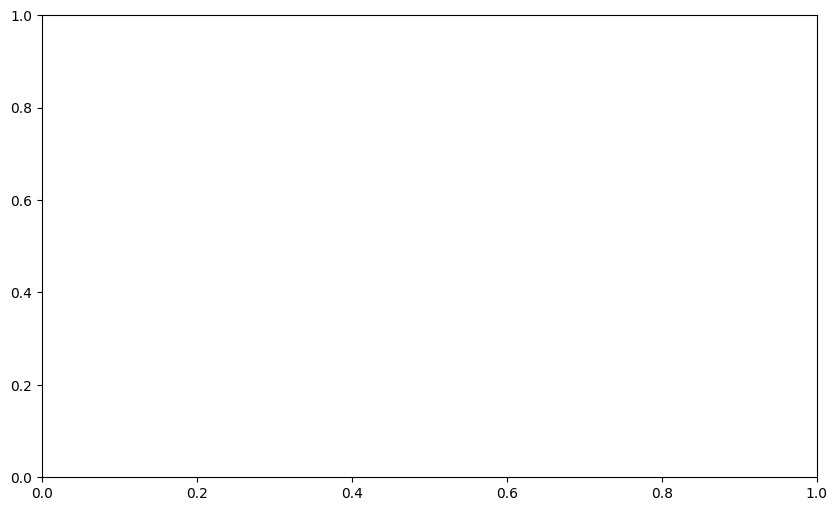

In [11]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import matplotlib.pyplot as plt

# Setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="kacong_ali_IndoNanoT5-base_25(2)",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=28,
    predict_with_generate=True,
    fp16=True,
    generation_max_length=70
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Extract training logs
log_history = trainer.state.log_history

# Prepare data for plotting
epochs = []
training_loss = []
validation_loss = []

for log in log_history:
    if "epoch" in log:  # Extract epoch information
        epochs.append(log["epoch"])
    if "loss" in log:  # Extract training loss
        training_loss.append(log["loss"])
    if "eval_loss" in log:  # Extract validation loss
        validation_loss.append(log["eval_loss"])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', linestyle='--')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [12]:
tokenized_test = test.map(preprocess_function, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [13]:
test_results = trainer.evaluate(tokenized_test)
print("Test BLEU score:", test_results["eval_bleu"])

Test BLEU score: 14.9484269270906


In [14]:
test_results

{'eval_loss': 2.4773921966552734,
 'eval_bleu': 14.9484269270906,
 'eval_gen_len': 48.345,
 'eval_runtime': 45.7002,
 'eval_samples_per_second': 8.753,
 'eval_steps_per_second': 0.547,
 'epoch': 28.0}

## SAVE AND LOAD

In [15]:
# BUAT NGESAVE KE LOCAL!!!
local_dir = "IndoNanoT5-base"

model.save_pretrained(local_dir)
tokenizer.save_pretrained(local_dir)

# NANTI CARA NGE LOAD NYA GINI!!
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# model = AutoModelForSeq2SeqLM.from_pretrained(local_dir)
# tokenizer = AutoTokenizer.from_pretrained(local_dir)

('IndoNanoT5-base/tokenizer_config.json',
 'IndoNanoT5-base/special_tokens_map.json',
 'IndoNanoT5-base/tokenizer.json')

## Inference

In [19]:
test

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 400
})

In [ ]:
import random
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained(local_dir)
tokenizer = AutoTokenizer.from_pretrained(local_dir)

def translate_and_compare_samples(test_data, num_samples=5):
    samples = random.sample(range(len(test_data['text_1'])), num_samples)
    
    for idx in samples:
        source_text = test_data['text_1'][idx]
        target_text = test_data['text_2'][idx]
        text = f"terjemahkan dari Bahasa Indonesia ke Bahasa Madura: {source_text}"
        inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)
        outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Sampel {idx + 1}")
        print("Source Text (Indonesia):", source_text)
        print("Translated Text (Madura):", translated_text)
        print("Target Text (Expected Madura):", target_text)
        print("=" * 50)

translate_and_compare_samples(test, num_samples=5)


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(local_dir)
tokenizer = AutoTokenizer.from_pretrained(local_dir)

text = "terjemahkan dari Bahasa Indonesia ke Bahasa Madura: gimana kabarmu?"

inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)
outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)

translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Translated text:", translated_text)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Inisialisasi model dan tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(local_dir)
tokenizer = AutoTokenizer.from_pretrained(local_dir)

# Teks masukan dalam bahasa Madura
text = "terjemahkan dari Bahasa Madura ke Bahasa Indonesia: Semmak bik hotel engkok nginep, pera' ejeleni ajelen soko, ediye bennyak sarah pelean kakananna, kenengngan se leber, ben masenneng"

# Tokenisasi input
inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)

# Generasi terjemahan
outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)

# Dekode hasil terjemahan
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Translated text:", translated_text)

In [16]:
import random
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import sacrebleu

# Inisialisasi model dan tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(local_dir)
tokenizer = AutoTokenizer.from_pretrained(local_dir)

# Fungsi untuk menerjemahkan dan membandingkan hasil dengan skor BLEU
def translate_and_compare_samples(test_data, num_samples=100):
    # Ambil beberapa sampel acak dari data test
    samples = random.sample(range(len(test_data['text_1'])), num_samples)

    # List untuk menyimpan hasil yang akan dikonversi menjadi tabel
    results = []

    for idx in samples:
        source_text = test_data['text_1'][idx]
        target_text = test_data['text_2'][idx]
        text = f"terjemahkan dari Bahasa Indonesia ke Bahasa Madura: {source_text}"
        
        # Tokenisasi dan terjemahan
        inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)
        outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
        
        # Dekode hasil terjemahan
        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Hitung skor BLEU
        bleu = sacrebleu.corpus_bleu([translated_text], [[target_text]]).score
        
        # Tambahkan hasil ke list
        results.append({
            "Source Text (Indonesia)": source_text,
            "Translated Text (Madura)": translated_text,
            "Target Text (Expected Madura)": target_text,
            "BLEU Score": bleu
        })

    # Konversi hasil ke dalam DataFrame pandas
    df_results = pd.DataFrame(results)
    return df_results

# Panggil fungsi dan tampilkan hasil dalam bentuk tabel
df_results = translate_and_compare_samples(test, num_samples=100)
df_results


KeyboardInterrupt: 

In [ ]:
df_results.to_csv("translation_nanot5_indomad.csv", index=False)